In [509]:
import sys, os
os.chdir('G:\My Drive\Documents\PhD\Modelling\_RiceBall')

In [510]:
import ricepaper
import ricepaper.postprocess as pp
from ricepaper import RicePaper
from ricepaper.reader import RiceBall
from ricepaper.dykes import DykeFarm

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [511]:
R = RicePaper("DykeTrigger")

The following sets up the basic material and numerical properties for our DEM and static boundaries for the volcano to sit on

In [512]:
#setup simulation as per La Palma demo
#material properties
resolutionFactor=1 #ball radii is divided by this, number of balls created multiplied by this
tsFactor=2 #ts is divided by this, number of steps multiplied by this
R.setRadius(1,30/resolutionFactor)  #radius 1 (volcano)
R.setRadius(2,25/resolutionFactor)  #radius 2 (volcano)
R.setRadius(3,20/resolutionFactor)  #boundary radius


R.setDensity(1,2500) #all 2500
R.setDensity(2,2500) 
R.setDensity(3,2500) 
R.setDensity(4,2500) 
R.setDensity(5,2500) 

R.setHertzian(1,2.9e9,0.2) #volcano type
R.setHertzian(2,2.9e9,0.2) #dyke type
R.setHertzian(3,2.9e9,0.2) #boundary type

#set cohesion between edifice and base particles
R.custom("COH 0.4 1 3")

In [513]:
R.setLinItc(1,1,2e10,2e10)
R.setLinItc(1,2,2e10,2e10)
R.setLinItc(1,3,2e10,2e10)
R.setLinItc(2,2,2e10,2e10)
R.setLinItc(2,3,2e10,2e10)
R.setLinItc(3,3,2e10,2e10)

R.setFrictionItc(1,1,0.2)
R.setFrictionItc(1,2,0.2)
R.setFrictionItc(1,3,0.2)
R.setFrictionItc(2,2,0.4) #dykes have higher friction angle 
R.setFrictionItc(2,3,0.2)
R.setFrictionItc(3,3,0.2)

In [514]:
#numerical properties
R.setDamping() #use defaults
R.setNumericalProperties(timestep=5e-2 / tsFactor)

#generate line of balls
R.genLine((25, 75, 50),(25, 4975, 50), 10, 3, 3) #left side
R.genLine((14975, 75, 50),(14975, 4975, 50), 10, 3, 3) #righth side
R.genLine((25, 25, 50),(14975, 25, 50), 10, 3, 3) #bottom side
R.fixDOFAll(True,True,True) #fix DOF on balls

R.setGravity((0,-9.8,0)) #set gravity

Next, we generate sets of balls which we let settle progressively to produce a gravitationally consolidated/settled pile. This provides the "starting material" for our edifice.

In [515]:
#create balls and cycle
activeColor = 'g'
altColor = 'b'
for i in range(6):
    R.setDomain(5000,10000,3500,6500,0,100) #domain to create balls in
    
    R.genBalls(250*resolutionFactor,1,1,color=activeColor)
    R.genBalls(500*resolutionFactor,2,1,color=activeColor)
    
    #fix rotation from this point onwards (to increase the internal angle of friction)
    R.setDomain(4999,10001,3499,6501,0,100)
    R.custom("PRP 1 FIX 0 0 0 1 1 1")

    R.cycle(2000*tsFactor)
    
    #flip color
    tmp = activeColor
    activeColor = altColor
    altColor = tmp
R.cycle(2000*tsFactor) #final cycle to let any other balls settle

7

In [516]:
#let these gravitationally settle to provide the starting material for our volcano
R.execute(suppress=True) #set supress = True if results have already been calculated and we just want to re-load

0

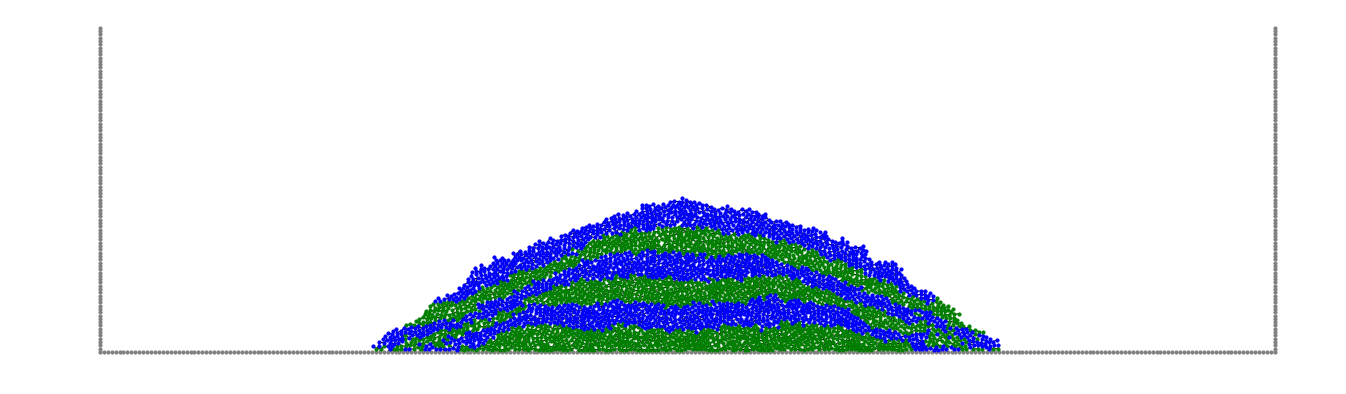

In [517]:
#quickly inspect
model = R.loadLastOutput()
model.quickPlot()

To get the desired volcano shape, we trim the edifice using cutting lines to give it a specific slope.

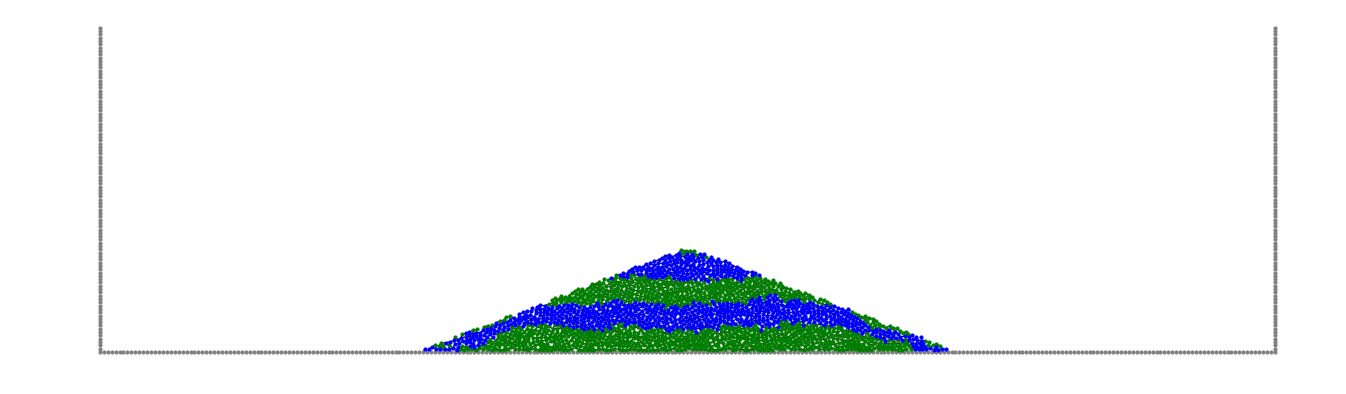

In [518]:
#shape volcano using cutting lines
deleted = []
deleted = model.cut(4000,25)
deleted += model.cut(11000,-25)
model.quickPlot()

In [519]:
#delete balls from model
R.delBalls(deleted,model.pos)

#turn off damping
R.setDamping(None,None)

Now things get a little more complicated. We "clone" the above model into two different forks - one in which we change nothing and simply let the edifice re-equilibrate (the "control" case), and the other in which we create a bunch of "strong" dykes before letting everything settle. These dykes are expected to change the stress distribution and strength of the bulk edifice, and hence change the stability and the associated evolution.

In [520]:
#clone model to create control set and dyke set
R_ctrl = R.clone("DykeTrigger/Control")
R_dyke = R.clone("DykeTrigger/Dykes")

We set up the dyke network by randomly selecting dyke locations and orientations (from the specified normal distributions) and then propagating "paths" as close to this orientation as possible through the edifice. To simulate dyke arrest, there is a certain probability of dyke arrest per propagation step.

In [521]:
#calculate dyke particles for dyke model
meanx = 7000
stdvx = 1000

meand = 90
stdvd = 20

np.random.seed(3)

#create dykes
dykes = []
farm = DykeFarm(model,p_arrest=0.015)

for i in range(50):
    #sample random position and ori
    pos = np.random.normal(meanx,stdvx)
    dip = np.random.normal(meand,stdvd)
    if dip > 90: #map dips > 90 to negative dips
        dip = dip - 180
        
    #make dyke
    dykes += farm.dykeFromOri(pos,dip,useCost=False)

In [522]:
#assign dykes to dykemodel
for n in dykes:
    R_dyke.setDomainToPos(model.pos[n]) #select node
    R_dyke.custom("PRP 1 COL x 6") #change dyke color to gray
    R_dyke.custom("PRP 1 SURf x 2 ") #change surface type to 2 (dyke)

#make bonds between dyke-particles within 60 meters (2r) 
domain = model.getBounds(dynamic=False)
R_dyke.custom("DOB %d %d %d %d 0 100" % domain) #set bounds for bonding to entire model domain
R_dyke.custom("BONd 1E7 1E7 5E3 5E3 2 2") #NOTE - I have no idea if these are even slightly reasonable numbers...

#calculage bond distance
rmax = max(model.radii.values())
R_dyke.custom("MKBonds %f 2 2" % (rmax * 2 + 1))  #TODO - avoid cross-dyke bonding...

Let the edifice restabilise and then inject a dyke into it to see what happens...

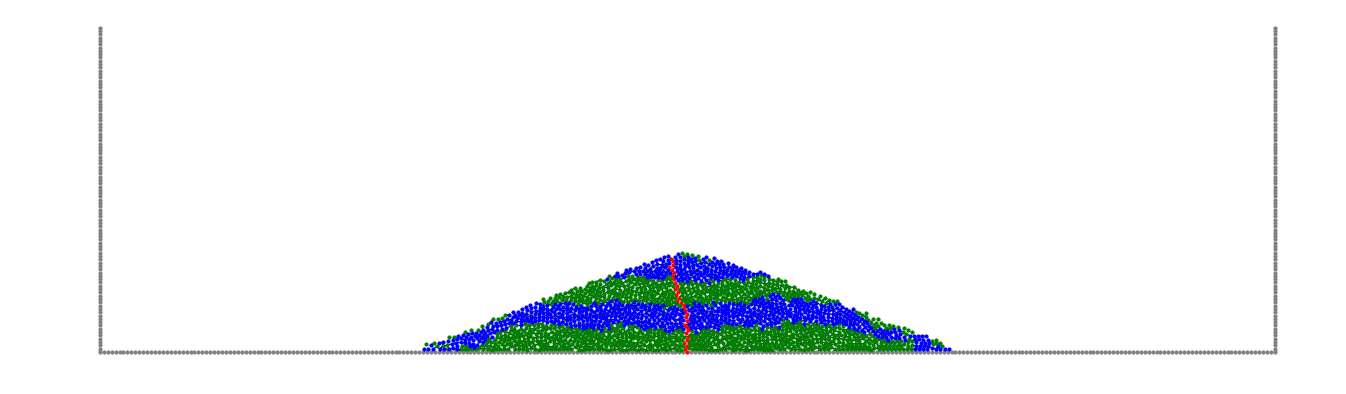

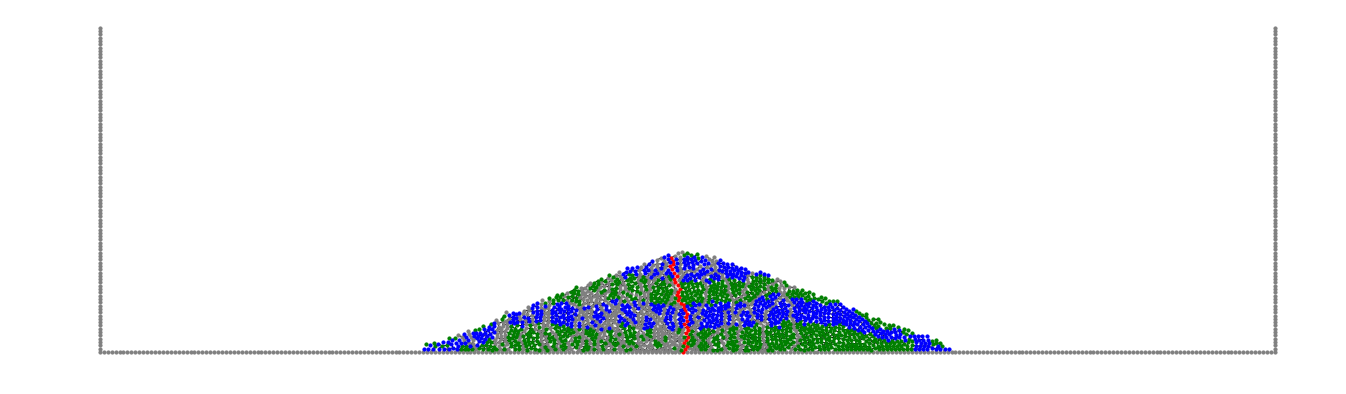

In [523]:
#let model stabilise and create new dyke
for i,R in enumerate([R_ctrl,R_dyke]):  
    #set timestep
    R.setNumericalProperties(timestep=2e-2/tsFactor)

    #let model re-equilibrate after load reduction (note that this *should* be stable & hence static)
    R.cycle(1000)
    R.execute(suppress=True)
    
    #load stabilised model
    model = R.loadLastOutput()
    
    #create active dyke
    farm = DykeFarm(model,p_arrest=0.0)
    dyke = farm.dykeFromOri(7500,-85,useCost=False)
    assert len(dyke) != 0, "Error creating active dyke..."
    
    #define dyke radii
    R.setRadius(4,30/resolutionFactor+5) #big particles
    R.setRadius(5,25/resolutionFactor+5) #small particles

    #apply to model
    for n in dyke:
        R.setDomainToPos(model.pos[n]) #select node
        R.custom("PRP 1 COL x 3") #change dyke color to lava red
        
        #change radius to "active dyke" radii
        #R.custom("PRP 1 SIZe x 4") #small-particle radii
        R.custom("PRP 1 SIZe x 5") #large-particle radii
        
    #execute (apply changes), load and plot
    R.cycle(1)
    R.execute(suppress=False)
    R.loadLastOutput().quickPlot()

In [524]:
#plot as model restabilises
outFiles = [] #keep track of expected output files
queue = [] #list of models to run
for i,R in enumerate([R_ctrl,R_dyke]):   
    for n in range(10):
        out.append(R.cycle(250)) #run until model restabilises
    
    #store output and queue model for running
    outFiles.append(out)
    queue.append(R)
    
#crunch models (control and the model with dykes are run in separate threads)
ricepaper.multiThreadExecute(queue,supress=False)

Launching job 1 of 2.
Launching job 2 of 2.


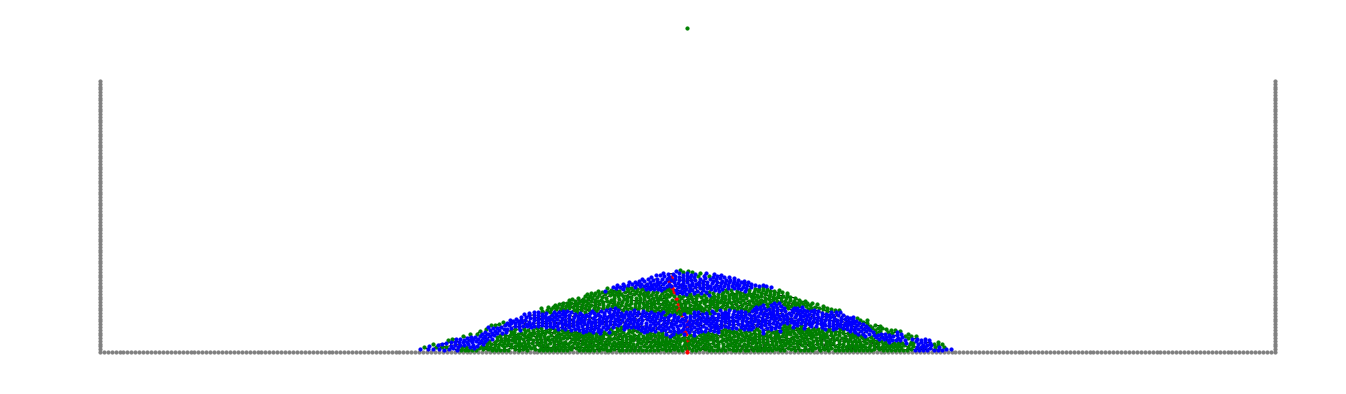

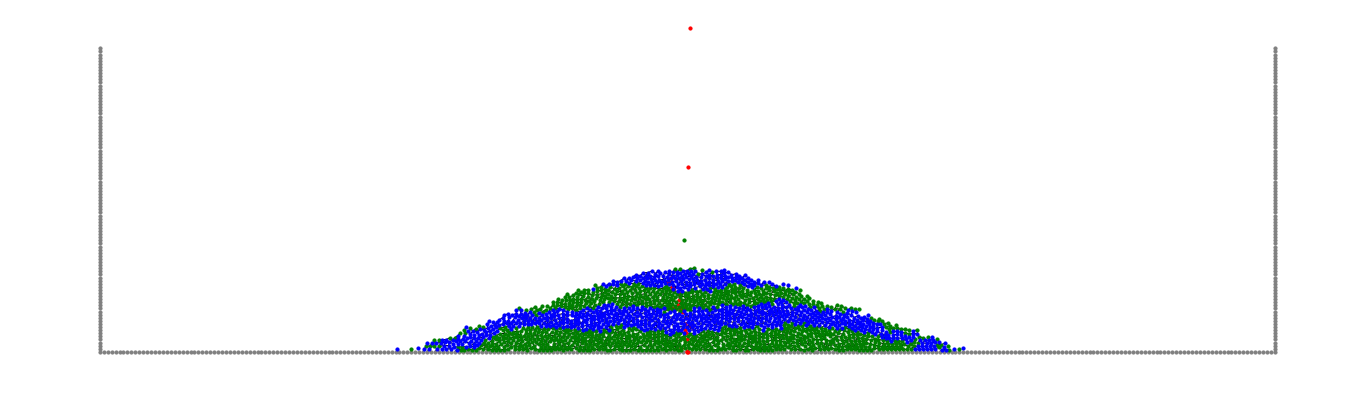

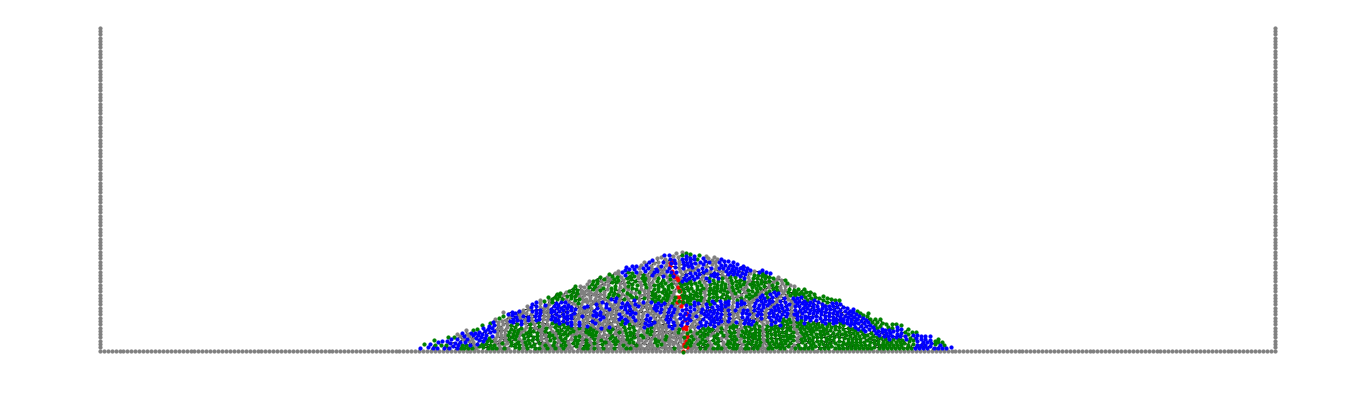

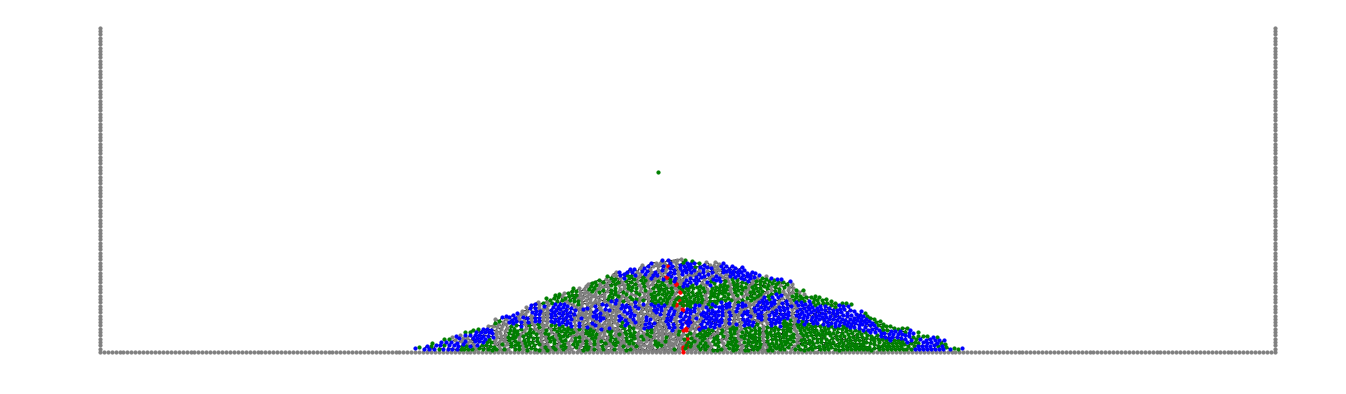

In [525]:
#load the results and plot
results = []
for i,R in enumerate(queue):
    #load steps
    steps = R.loadSteps(outFiles[i])
    
    #build vtk output directory
    vtkPath = os.path.join(R.dir,"vtk")
    if not os.path.exists(vtkPath):
            os.makedirs(os.path.join(R.dir,"vtk"))
    
    #export to vtk
    for n,m in enumerate(steps[1:]):
        #m.computeParticleStresses()
        #m.computeParticleDisplacements(steps[n])
        m.writeVTK(os.path.join(vtkPath,"STEP_%03d" % outFiles[i][n+1]))
        
    #quickly plot first and last model
    #for s in steps:
    #    s.quickPlot()
    steps[0].quickPlot()
    steps[-1].quickPlot()
    
    #store
    results.append(steps)

Now that we have loaded the model we can postprosses them to look at differences in stress state, strain localisation, stable slope angle etc.

In [475]:
def postProcess(models,dx=100):
    dy = dx #is a square grid so dy = dx, but using dx everywhere makes the calculus confusing
    for i,m in enumerate(models[1:]):
        m.computeParticleStresses()
        m.computeParticleDisplacements(models[i-1]) #compare with previous model
        
        #grid velocity components
        Vx,Vy = pp.gridModel( m, ["UDOT.x","UDOT.y"], dx)
        
        #plot speed
        pp.quickPlot(np.sqrt(Vx**2 + Vy**2),cmap="viridis")
        
        #"speed" gradient
        if True:       
            V_norm = np.sqrt(Vx**2 + Vy**2) #create grid of velocity magnitude
            grad = np.dstack(np.gradient(V_norm,dx))
            grad = np.linalg.norm(grad,axis=2)
            pp.quickPlot(grad,cmap="viridis")
        
        #velocity gradient
        if False:
            vxx, vxy = np.gradient(Vx,dx)
            vyx, vyy = np.gradient(Vy,dy)
            L = np.array([[vxx,vxy],[vyx,vyy]])

            #split deformation and rotational components:

            #rate of deformation tensor
            Dxx = vxx
            Dxy = 1/2. * (vxy + vyx)
            Dyx = Dxy
            Dyy = vyy

            #spin tensor
            Lxx = 0
            Lxy = 1/2. * (vxy - vyx)
            Lyx = 1/2. * (vyx - vxy)
            Lyy = 0
        
        
            #extract "rate of expansion" and "rate of shear" scalars from the rate of deformation tensor
            J = 1/2. * (Dxx + Dyy) #expansion term
            S = Dxy #shear term

            #plot
            pp.quickPlot(J,cmap="viridis")
            pp.quickPlot(np.abs(S),cmap="viridis")

        #strain tensor
        if True:
            #grid displacement vectors
            ux,uy = pp.gridModel( m, "disp", dx) 
            
            #plot displacement field
            pp.quickPlotV(np.dstack([ux,uy]),cmap="viridis",normed=False,scale=1e4,headwidth=0)
            
            #compute deformation gradient tensor
            Fxx,Fxy = np.gradient(ux,dx)
            Fyx,Fyy = np.gradient(uy,dy)
            
            #compute greens strain tensor
            Sxx = Fxx - 1
            Sxy = 1/2. * (Fxy + Fyx) 
            Syx = Sxy
            Syy = Fyy - 1
            
            #calculate strain invariants
            shear_strain = Sxy + Syx
            dilation  = 1/2. * (Sxx + Syy) + 1
            
            #get min/max for plotting
            maxss = 5#np.nanmax(np.abs(shear_strain))
            maxdl = 1#np.nanmax(np.abs(dilation))
            
            pp.quickPlot(shear_strain,cmap="RdBu",clim=(-maxss,maxss),)
            pp.quickPlot(dilation,cmap="RdBu",clim=(-maxdl,maxdl))

        if False:
            #plot differential stress and sig1 trajectories
            dif = pp.gridModel( m,"dif",dx)
            sig1 = np.dstack(pp.gridModel( m,"sigma1",dx))
            pp.quickPlotV(sig1,cmap="viridis",scale=30,headwidth=0,color="k")
            pp.quickPlot(dif, cmap="viridis")

In [476]:
#postprocess control model
postProcess(results[4])

IndexError: list index out of range

In [ ]:
len(results[0])

In [ ]:
#and for dyke model
#postProcess(results[1])

In [ ]:
m0 = results[10][0]
m1 = results[10][1]
postProcess([m0,m1])

dykes = []
non_dykes = []
m = results[1][0][5]
for n in m.G.nodes:
    mat = int(m.G.nodes[n]["MTYPE"])
    dif = m.G.nodes[n]["dif"]
    if mat == 1: #non-dyke
        non_dykes.append(dif)
    if mat == 2: #dyke
        dykes.append(dif)
control = []
m = results[0][0][5]
for n in m.G.nodes:
    mat = int(m.G.nodes[n]["MTYPE"])
    dif = m.G.nodes[n]["dif"]
    if mat == 1: #non-dyke
        control.append(dif)

plt.figure(figsize=(18,5))
plt.violinplot([dykes,non_dykes,control],showmeans=True,vert=False)
plt.show()

In [ ]:
out

In [ ]:
m.G.nodes[1]

In [ ]:
np.eye(2)